# Reducers

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 010-reducers.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]
os.environ["http_proxy"] = ""
os.environ["https_proxy"] = ""

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [2]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## What is a reducer?
* Reducer functions specify how state is updated.

## By default, when you update the state the new value overwrites the old value

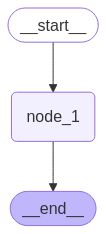

In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"foo" : 10})

---Node 1---


{'foo': 11}

* As you see, after running the app the new key value (11) overwrites the initial key value (10).

## This will be problematic if several nodes try to update the same key value at the same time

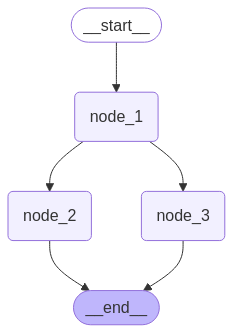

In [5]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 10}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 20}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"foo" : 10})

---Node 1---
---Node 2---
---Node 3---


InvalidUpdateError: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [7]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 20})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


* As you can see, this is a problem.

## Reducers can modify the default way to update the state

#### For example, let's append the value returned from each node rather than overwriting them.

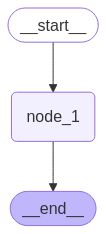

In [8]:
# add is a function from Python's built-in operator module
from operator import add
from typing import Annotated

# When the add operator is applied to lists, 
# it performs list concatenation.
class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

* As you see, using a reducer we can change the default way of updating the state.
* We can also use **custom reducers**. Just define the reducer functiona an include it in the state schema:

In [10]:
# We would customize this reducer function. Right now it does nothing. 
def my_custom_reducer():
    pass

class State(TypedDict):
    foo: Annotated[list[int], my_custom_reducer]

## The add_messages Reducer

* The following two state schemas are equivalent. MessagesState is more frequently used.
    * It has a built-in messages key.
    * It also has a built-in add_messages reducer for this key.

In [11]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages 
# with add_messages reducer
class LongerMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with 
# add_messages reducer
class CompactMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

* As you can see below, **add_messages allows us to append messages to the messages key in the state:**

In [12]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?"),
                    HumanMessage(content="I'm looking for information on Rosemary Kenney.")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, id='f9689e0f-e9f2-48cf-9b0d-6bc73e1e5f7f'),
 HumanMessage(content="I'm looking for information on Rosemary Kenney.", additional_kwargs={}, response_metadata={}, id='a8c690c5-4a13-4374-9cee-950a43a2c382'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, id='cbb2db27-a0ee-47b7-aa60-4e2ba98e67e9')]

* **If we pass a message with the same ID as an existing one in our messages list, it will get overwritten:**

In [13]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", id="1"),
                    HumanMessage(content="I'm looking for information on Donald Trump.", id="2")
                   ]

# New message with the same id as the previous one
new_message = HumanMessage(content="I'm looking for information on Joe Biden", id="2")

# When we use add_messages, the message with the same id will get overwritten
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, id='1'),
 HumanMessage(content="I'm looking for information on Joe Biden", additional_kwargs={}, response_metadata={}, id='2')]

* **add_messages also enables message removal:**

In [14]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", id="1")]
messages.append(HumanMessage("Hi.", id="2"))
messages.append(AIMessage("So you said you were researching on the Kennedys?", id="3"))
messages.append(HumanMessage("Yes, I know about JFK. But what others should I learn about?", id="4"))

# Delete the first 2 messages
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [15]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching on the Kennedys?', additional_kwargs={}, response_metadata={}, id='3'),
 HumanMessage(content='Yes, I know about JFK. But what others should I learn about?', additional_kwargs={}, response_metadata={}, id='4')]

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 010-reducers.py file
* In terminal, make sure you are in the directory of the file and run:
    * python 010-reducers.py file